In [24]:
import os
import pathlib

import pandas as pd

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [25]:
!pip install ktrain
import ktrain
from ktrain import text
MODEL_NAME="m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
train_path= "../input/training-e-test-set-normalizzati/haspeede2_dev_taskAB.csv(Normalizzato).csv"
test_path="../input/training-e-test-set-normalizzati/haspeede2_test_taskAB-tweets(Normalizzato).csv"

tr_path=pathlib.Path(train_path)
te_path=pathlib.Path(test_path)

if tr_path.exists():
    print("Train data path set.")
else:
    raise SystemExit("Training Data Path does not exist.")

if te_path.exists():
    print("Test data path set.")
else:
    raise SystemExit("Test Data Path does not exist.")

Train data path set.
Test data path set.


In [27]:
train_df= pd.read_csv(train_path, encoding='utf-8', sep=";", header=None)
train_df=train_df.drop([0])
train_df.head()

,0,1,2
1,2066,"è terrorismo anche questo , per mettere in uno...",0
2,2045,<user> <user> infatti finché ci hanno guadagna...,0
3,61,"corriere : tangenti , mafia capitale dimentica...",0
4,1259,"<user> ad uno ad uno , perché quando i migrant...",0
5,949,il divertimento del giorno ? trovare i patriot...,0


In [28]:
test_df= pd.read_csv(test_path, encoding='utf-8', sep=";",header=None)
test_df=test_df.drop([0])
test_df.head()

,0,1,2
1,11834,<user> a me pare una scelta politica suicida p...,1
2,12113,<user> e ' un perfetto musulmano ! <repeated> ...,1
3,11770,mai tg e i giornaloni hanno parlato di questa ...,1
4,11937,<user> ipocriti farabutti . fanno morire i ter...,1
5,11870,<user> <user> <user> l ' <allcaps> immigrazion...,1


In [29]:
x_train=train_df[1].tolist()
y_train=train_df[2].tolist()
x_test=test_df[1].tolist()
y_test=test_df[2].tolist()

preprocessing train...
language: it
train sequence lengths:
	mean : 32
	95percentile : 61
	99percentile : 72


Is Multi-Label? False
preprocessing test...
language: it
test sequence lengths:
	mean : 47
	95percentile : 67
	99percentile : 79


simulating training for different learning rates... this may take a few moments...
Epoch 1/10
213/213 [==============================] - 99s 379ms/step - loss: 0.6931 - accuracy: 0.5303
Epoch 2/10
213/213 [==============================] - 82s 387ms/step - loss: 0.6193 - accuracy: 0.6347
Epoch 3/10
213/213 [==============================] - 82s 386ms/step - loss: 0.4885 - accuracy: 0.7546
Epoch 4/10
213/213 [==============================] - 82s 386ms/step - loss: 0.3949 - accuracy: 0.8143
Epoch 5/10
213/213 [==============================] - 82s 386ms/step - loss: 0.4904 - accuracy: 0.7450
Epoch 6/10
213/213 [==============================] - 82s 386ms/step - loss: 0.7195 - accuracy: 0.5588
Epoch 7/10
213/213 [==============================] - 74s 349ms/step - loss: 1.2362 - accuracy: 0.5332


done.
Visually inspect loss plot and select learning rate associated with falling loss


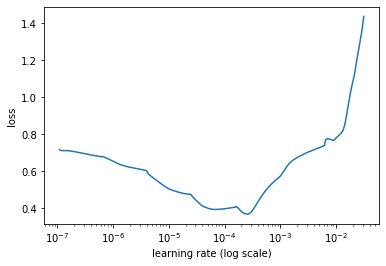



begin training using triangular learning rate policy with max lr of 0.0002...
Epoch 1/10
214/214 [==============================] - 101s 408ms/step - loss: 0.6193 - accuracy: 0.6461 - val_loss: 0.5461 - val_accuracy: 0.7379
Epoch 2/10
214/214 [==============================] - 88s 401ms/step - loss: 0.4470 - accuracy: 0.8002 - val_loss: 0.6974 - val_accuracy: 0.5075
Epoch 3/10
214/214 [==============================] - 88s 401ms/step - loss: 0.6796 - accuracy: 0.5857 - val_loss: 0.6992 - val_accuracy: 0.5075
Epoch 4/10
214/214 [==============================] - 88s 401ms/step - loss: 0.6821 - accuracy: 0.5816 - val_loss: 0.7242 - val_accuracy: 0.5075
Epoch 5/10
214/214 [==============================] - 88s 401ms/step - loss: 0.6827 - accuracy: 0.5834 - val_loss: 0.7230 - val_accuracy: 0.5075
Epoch 6/10
214/214 [==============================] - 88s 401ms/step - loss: 0.6820 - accuracy: 0.5840 - val_loss: 0.7052 - val_accuracy: 0.5075
Restoring model weights from the end of the best 

array([[454, 187],
       [144, 478]])

In [30]:
t=text.Transformer(MODEL_NAME,maxlen=100)
trn=t.preprocess_train(x_train,y_train)
val=t.preprocess_test(x_test,y_test)

model=t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

learner.lr_find(show_plot=True,max_epochs=10)
#learner.lr_plot(return_fig=True)
learner.autofit(2e-4,early_stopping=5,epochs=10)
learner.validate(class_names=t.get_classes())


In [31]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

data=test_df[1].tolist()
label=test_df[2].tolist()

i = 0
correct = 0
wrong = 0
total = len(data)
true_lab = []
pred_lab = []
text = []
for dt in data:
    result = predictor.predict(dt)
    if not result == label[i]:
        text.append(dt)
        pred_lab.append(result)
        true_lab.append(label[i])
        wrong += 1
    else:
        correct += 1

    i += 1

name_dict = {
    'Name': text,
    'Gold Label': true_lab,
    'Predicted Label': pred_lab
}

wrong_data = pd.DataFrame(name_dict)

wrong_data.to_csv("wrong_results.csv", sep=';')

print("Correct: ", correct,"/",total,"\nWrong: ", wrong,"/",total)


Correct:  932 / 1263 
Wrong:  331 / 1263
